<a href="https://colab.research.google.com/github/linadrozd/ai_banana/blob/main/banana_05_val_loss_inc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import torch
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.utils import make_grid
from google.colab import files 
import pandas as pd

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH_OF_DATA= '/content/gdrive/"My Drive"/Ai'
!ls {PATH_OF_DATA}

banana_test  banana_train


In [ ]:
torch.manual_seed(42)
dataset = ImageFolder(root="/content/gdrive/My Drive/Ai/banana_train", transform=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))
dataset_size = len(dataset)
dataset_size
classes = dataset.classes
classes
num_classes = len(dataset.classes)
num_classes
test_size = round(dataset_size*0.10)
nontest_size = len(dataset) - test_size
nontest_ds, test_ds = random_split(dataset, [nontest_size, test_size])
len(nontest_ds), len(test_ds)
val_size = round(dataset_size*0.10)
train_size = len(nontest_ds) - val_size
train_ds, val_ds = random_split(nontest_ds, [train_size, val_size])
len(train_ds), len(val_ds)
batch_size = 4

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
class CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
nn.Flatten(), 
            nn.Linear(256*16*16 * 4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)
model = CnnModel()
model

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)
def __len__(self):
        """Number of batches"""
        return len(self.dl)
       
device = get_default_device()
device

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history
model = to_device(CnnModel(), device)
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break
num_epochs1 = 5
num_epochs2 = 5
num_epochs3 = 5
opt_func = torch.optim.Adam
lr1 = 0.000010
lr2 = 0.0000005
lr3 = 0.0000001
evaluate(model, val_dl)
history = fit(num_epochs1, lr1, model, train_dl, val_dl, opt_func)

history = fit(num_epochs2, lr2, model, train_dl, val_dl, opt_func)
history = fit(num_epochs3, lr3, model, train_dl, val_dl, opt_func)

images.shape: torch.Size([4, 3, 256, 256])
out.shape: torch.Size([4, 10])
out[0]: tensor([ 0.0116,  0.0134,  0.0292, -0.0077,  0.0375,  0.0366,  0.0356,  0.0169,
        -0.0217, -0.0204], device='cuda:0', grad_fn=<SelectBackward>)
Epoch [0], train_loss: 0.4447, val_loss: 0.0531, val_acc: 0.9844
Epoch [1], train_loss: 0.0477, val_loss: 0.0318, val_acc: 0.9861
Epoch [2], train_loss: 0.0372, val_loss: 0.0294, val_acc: 0.9896
Epoch [3], train_loss: 0.0310, val_loss: 0.0267, val_acc: 0.9913
Epoch [4], train_loss: 0.0194, val_loss: 0.0494, val_acc: 0.9913
Epoch [0], train_loss: 0.0133, val_loss: 0.0209, val_acc: 0.9931
Epoch [1], train_loss: 0.0097, val_loss: 0.0211, val_acc: 0.9931
Epoch [2], train_loss: 0.0091, val_loss: 0.0213, val_acc: 0.9948
Epoch [3], train_loss: 0.0081, val_loss: 0.0241, val_acc: 0.9948
Epoch [4], train_loss: 0.0077, val_loss: 0.0225, val_acc: 0.9948
Epoch [0], train_loss: 0.0069, val_loss: 0.0218, val_acc: 0.9948
Epoch [1], train_loss: 0.0067, val_loss: 0.0216, val_

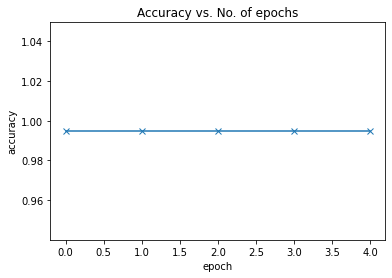

In [ ]:

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
plot_accuracies(history)

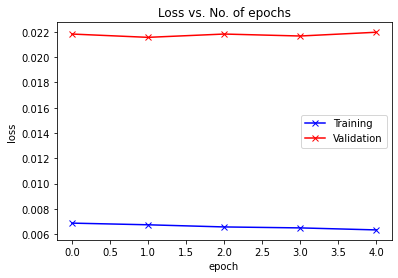

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:

print('val loss:', history[-1]['val_loss'])
print('val acc:', history[-1]['val_acc'])

val loss: 0.02337842620909214
val acc: 0.9947916865348816


In [ ]:
print(history)

[{'val_loss': 0.02182203158736229, 'val_acc': 0.9947916865348816, 'train_loss': 0.006881132256239653}, {'val_loss': 0.0215605478733778, 'val_acc': 0.9947916865348816, 'train_loss': 0.006749514490365982}, {'val_loss': 0.02182156778872013, 'val_acc': 0.9947916865348816, 'train_loss': 0.006579600740224123}, {'val_loss': 0.021666698157787323, 'val_acc': 0.9947916865348816, 'train_loss': 0.006503749173134565}, {'val_loss': 0.02196400612592697, 'val_acc': 0.9947916865348816, 'train_loss': 0.006344235502183437}]


In [ ]:
evaluate(model, val_dl)
history = fit(num_epochs1, lr1, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0151, val_loss: 0.0378, val_acc: 0.9861
Epoch [1], train_loss: 0.0108, val_loss: 0.0167, val_acc: 0.9931
Epoch [2], train_loss: 0.0070, val_loss: 0.0184, val_acc: 0.9948
Epoch [3], train_loss: 0.0015, val_loss: 0.0273, val_acc: 0.9913
Epoch [4], train_loss: 0.0085, val_loss: 0.0122, val_acc: 0.9965


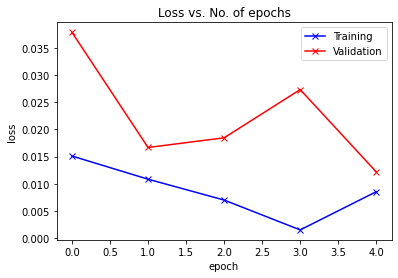

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
evaluate(model, val_dl)
history = fit(num_epochs2, lr2, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.0008, val_loss: 0.0107, val_acc: 0.9965
Epoch [1], train_loss: 0.0005, val_loss: 0.0125, val_acc: 0.9965
Epoch [2], train_loss: 0.0003, val_loss: 0.0143, val_acc: 0.9965
Epoch [3], train_loss: 0.0002, val_loss: 0.0140, val_acc: 0.9965
Epoch [4], train_loss: 0.0002, val_loss: 0.0152, val_acc: 0.9965


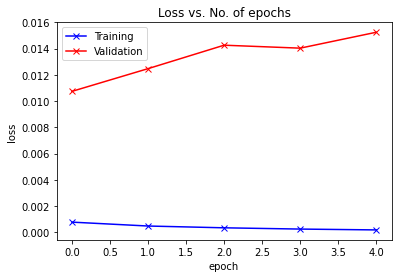

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(history)

In [ ]:
model_save_name = 'banana_14_04_epoch5.pt'
PATH = F"/content/gdrive/My Drive/Ai/{model_save_name}" 

torch.save(model.state_dict(), PATH)

AttributeError: ignored

NameError: ignored

In [ ]:
model = CnnModel()
model.load_state_dict(torch.load(PATH))
model.eval()

CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=262144, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_features=